# Gradient Pred


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
import matplotlib.patches as patches

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import os
import json
import time
from io import StringIO
from datetime import datetime
import re
import math
import pyaml
import multiprocessing

from sklearn.linear_model import LinearRegression
from scipy import integrate

import sys
sys.path.append("/Users/dteng/Documents/bin/nmr_utils/")
from nmr_targeted_utils import *
from nmr_fitting_new_funcs import *

conc_dict = {
      "01":5104,
      "02":2041.6,
      "03":1020.8,
      "04":816.64,
      "05":510.4,
      "06":306.24,
      "07":127.6,
      "08":51.04,
      "09":25.52,
      "10":10.208,
      "11":0
   }


In [2]:
# params
template_path = "/Users/dteng/Documents/zdata/nmr/nmr_std_data/indiv_std_lproline/lproline_ph3.csv"
bs_grad_path = "/Users/dteng/Documents/nmr_targeted/mlgrad/results/bootstrap_results.csv"
matching_path = "/Users/dteng/Documents/zdata/nmr/nmr_std_data/lr_matching_coords/lproline_ph3_matching_regions.csv"
#template_path = "/Users/dteng/Documents/bin/nmr_constants/cal_data_pro/pro_stds/pro_std_03_r1.csv"

# diff mcoords for neat-pro-std or pro_std_03
if "pro_std_03" in template_path:
    multiplets_ls = [[1.9,2.15], [2.304, 2.408],[3.25, 3.5],[4.1, 4.2]]
if "lproline_ph3" in template_path:
    multiplets_ls = [[1.9,2.15], [2.295, 2.403], [3.25, 3.5],[4.1, 4.2]]
std_matching_method = "bounded-lmse"

#signal_free_coords = [-1, 10] # signal free region is outside of these coords

normxcorr_th = 0.0 # set to this number to filter out multiplets which aren't at least normxcorr_th, i.e. poor fits
ref_pk_window = [-0.02, 0.02]
ref_pk_tolerance_window = [0,0]
search_region_padding_size = 0.02

suffix = template_path.split("/")[-1].replace(".csv", "")
fn_out_plot = f"mlgrad_{suffix}.html"
fn_out_df = f"mlgrad_{suffix}.csv"

# Load Data

In [3]:
# ========== load data ==========
# load STD template(s)
template_df = pd.read_csv(template_path)
template_df = adjust_to_ref_peak(template_df, ref_pk_window, ref_pk_tolerance_window)

# load bootstrap gradients
d_bs_grad = pd.read_csv(bs_grad_path)
print(f"Loaded {len(d_bs_grad)} bootstrapped gradients")

# load flynn's manual calcs
#d_manual = pd.read_csv(manual_calc_path)

# load validation data - HS, LS and NS
path_samples = "/Users/dteng/Documents/zdata/nmr/temp/Proline20210423"
#path_samples = "/Users/dteng/Documents/bin/nmr_constants/cal_data_pro/pro_stds"
df_dict = {}
for fn in os.listdir(path_samples):
    if ".csv" in fn:
        k = fn.replace(".csv", "")
        df_dict[k] = pd.read_csv(os.path.join(path_samples, fn))
        
# load more validation data - original cal stds
path_samples = "/Users/dteng/Documents/bin/nmr_constants/cal_data_pro/pro_stds"
for fn in os.listdir(path_samples):
    if ".csv" in fn:
        k = fn.replace(".csv", "")
        df_dict[k] = pd.read_csv(os.path.join(path_samples, fn))
        
d_matching = pd.read_csv(matching_path)

print(f"Loaded {len(df_dict)} validation samples")

Loaded 10000 bootstrapped gradients
Loaded 47 validation samples


# Run

In [4]:
# ===== run 1d_std_search =====
results_dict = {}
for k in sorted(list(df_dict.keys())):
    target_df = df_dict[k]
    results_dict[k] = do_1d_std_search(
        query_df=template_df, 
        target_df=target_df,                                       
        multiplets_ls=multiplets_ls,           
        search_region_padding_size=search_region_padding_size
    )
    
# ===== run LR matching =====
df_conc, blue_m1_dict = get_df_conc_lrmatching(
    results_dict=results_dict, 
    template_df=template_df.copy(), 
    df_dict=df_dict, 
    mcoords=multiplets_ls[1],
    matching_coords_ls=d_matching.values
)


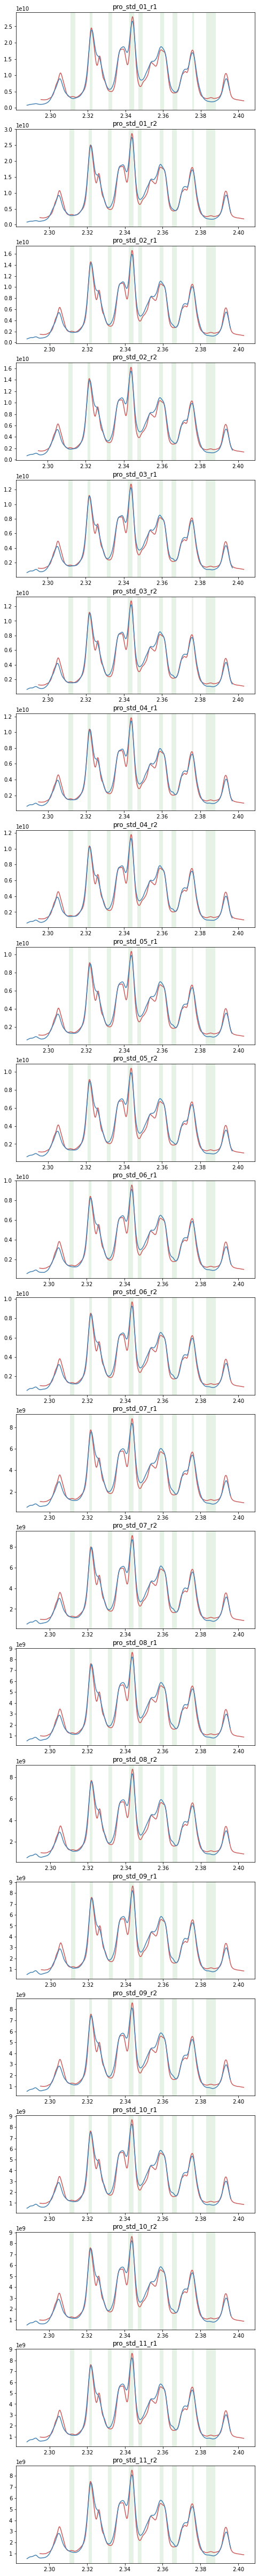

In [6]:
# Look at fits for cal stds, figure out why they're so off

temp_ls = []
for k in sorted(list(results_dict.keys())):
    ]temp_ls.append(k)

fig, ax = plt.subplots(nrows=len(temp_ls), 
                       ncols=1, 
                       figsize=(8, len(temp_ls)*4))

red_dt = template_df.copy()
red_dt = red_dt.loc[(red_dt["ppm"]>min(multiplets_ls[1])) & (red_dt["ppm"]<max(multiplets_ls[1]))]

i = 0
for k in temp_ls:
    ppm_shift = results_dict[k]["multiplet_1"]["ppm_shift"]
    
    m = df_conc.loc[df_conc["sample_name"]==k]["slope"].values[0]
    c = df_conc.loc[df_conc["sample_name"]==k]["intercept"].values[0]
    
    # plot reds 
    ax[i].plot(red_dt.ppm.values, 
             (red_dt.intensity.values*m)+c, 
             c="indianred"
            )
    
    blue_dt = blue_m1_dict[k].copy()
    
    # plot blues
    ax[i].plot(blue_dt.ppm.values, 
              blue_dt.intensity.values, 
              c="steelblue")
    
    ax[i].set_title(k)
    
    # show matching regions
    for idx, row in d_matching.iterrows():
        # Draw a rectangle with transparency
        ax[i].axvspan(float(row["min"]), 
                   float(row["max"]), 
                   facecolor="green", 
                   alpha=0.1)

    i += 1
    
plt.show()

# Get conc_preds

In [7]:
# get AUCs multiplied by all bootstrapped gradients in a matrix
# get conc_pred
auc_m = np.matmul(df_conc["auc"].values.reshape(-1, 1), 
                  d_bs_grad.values.reshape(1, -1))

# get ave +/- 95% CI
c = []
for i in range(len(auc_m)):
    ave = np.average(auc_m[i])
    std = np.std(auc_m[i], ddof=1)
    ci_lower = np.percentile(auc_m[i], 2.5)
    ci_upper = np.percentile(auc_m[i], 97.5)
    c.append([df_conc["sample_name"].values[i], ave, std, ci_lower, ci_upper])

d_concpred = pd.DataFrame(data=c, 
                          columns=["sample_name", 
                                   "conc_pred_ave", 
                                   "conc_pred_sd", 
                                   "95_ci_lower", 
                                   "95_ci_upper"]
                         )

# Report Plot

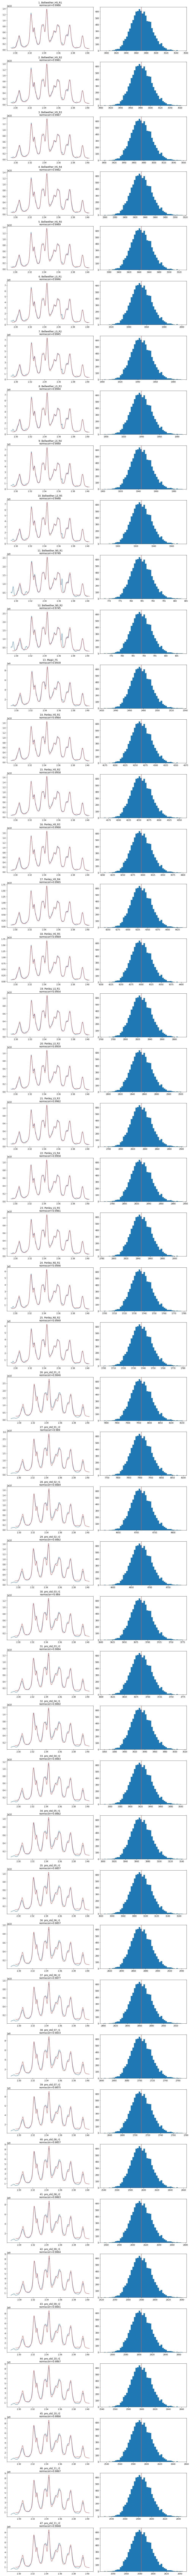

In [8]:
# plot match results
fig, ax = plt.subplots(nrows=len(results_dict), # top row for LR results
                       ncols=2, 
                       figsize=(14, len(results_dict)*4)
                      )

red_dt = template_df.copy()
red_dt = red_dt.loc[(red_dt["ppm"]>min(multiplets_ls[1])) & (red_dt["ppm"]<max(multiplets_ls[1]))]

i = 0
for k in sorted(list(results_dict.keys())):
    # plot fit
    normxcorr = results_dict[k]["multiplet_1"]["max_rho"][0]
    ax[i, 0].plot(blue_m1_dict[k].ppm.values, 
               blue_m1_dict[k].intensity.values, c="steelblue")
    
    m = df_conc.loc[df_conc["sample_name"]==k]["slope"].values[0]
    c = df_conc.loc[df_conc["sample_name"]==k]["intercept"].values[0]
    ax[i, 0].plot(red_dt.ppm.values, 
               (red_dt.intensity.values*m)+c, 
               c="indianred")
    
    ax[i, 0].set_title(f"{i+1}. {k}\nnormxcorr={round(normxcorr, 4)}")
    
    # plot histogram
    ax[i, 1].hist(auc_m[i], bins=50)
    ax[i, 1].axvline(np.average(auc_m[i]), c="indianred")
    
    # disabled atm because normxcorr doesn't really work
    # set bg colour
    # bg_colour = "#FE9FA5"
    # if normxcorr > 0.85 and normxcorr < 0.99:
    #     bg_colour = "#FEDA96"
    # elif normxcorr >= 0.99:
    #     bg_colour = "#96FEBF"
    # ax[i].set_facecolor(bg_colour)
    # plt.setp(ax[i].get_xticklabels(), fontsize=20)
    # plt.setp(ax[i].get_yticklabels(), fontsize=20)

    i += 1

plt.subplots_adjust(hspace=0.2, wspace=0)
plt.tight_layout()

i = StringIO()
fig.savefig(i, format="svg")
output_svg = i.getvalue().strip().split("\n")
svg_ls = resize_svg(output_svg, resize_coeff=0.5)

In [9]:
# ===== prep html report =====
# not written as a function because of the sheer number of inputs required

html_contents = ["<html><head></head><body>"]

html_contents.append("<ul>")
html_contents.append(f"<li>Report generated: {datetime.today().strftime('%d %b %y, %-I:%M%p')}</li>")
html_contents.append(f"<li>num_samples = {len(results_dict)}</li>")
html_contents.append(f"<li>template = {template_path.split('/')[-1]}</li>")
html_contents.append(f"<li>normxcorr threshold = {normxcorr_th}</li>")
html_contents.append(f"<li>ref peak window = {ref_pk_window}</li>")
html_contents.append(f"<li>ref peak tolerance window = {ref_pk_tolerance_window}</li>")
html_contents.append(f"<li>search region padding size (ppm) = {search_region_padding_size}</li>")
#html_contents.append(f"<li>Output csv = {fn_out_df}</li>")
html_contents.append("</ul>")

html_contents.append("<hr>")
for line in output_svg:
    html_contents.append(line)
html_contents.append("</body></html>")

# ===== write out everything =====
# make foldername
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
folder_name = f"./results/mlgrad-pred-{template_path.split('/')[-1].replace('.csv', '')}-{timestamp}"
os.makedirs(folder_name, exist_ok=True)

with open(f"./{folder_name}/{fn_out_plot}", "w") as f:
    for line in html_contents:
        f.write(line)
        
fn_out_concpred = os.path.join(folder_name, "concpred.csv")
d_concpred.to_csv(fn_out_concpred, index=False)
print(f"Wrote out to {fn_out_concpred}")

print(f"Wrote out to:")
print(folder_name)
print(f"{fn_out_plot}")

Wrote out to ./results/mlgrad-pred-lproline_ph3-20230807_1818/concpred.csv
Wrote out to:
./results/mlgrad-pred-lproline_ph3-20230807_1818
mlgrad_lproline_ph3.html
